# Assignment 3
## Question 1: Siamese networks & one-shot learning (8pt)
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much less examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

In [3]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras import backend as K
from keras.utils import to_categorical
from keras.regularizers import l2
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar100
import pickle

# load the dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode="fine")
y_train = y_train.flatten()
y_test = y_test.flatten()

# transform the dataset
img_rows, img_cols, chns = 32, 32, 3
n_classes = 100

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

# normalise the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# find the order of indices that sort the datasets by label
sort_indices_train = y_train.argsort()
sort_indices_test = y_test.argsort()

# sort the data by label, and reshape into (n_classes, n_examples, width, height, depth)
x_train_sorted = x_train[sort_indices_train]
x_test_sorted = x_test[sort_indices_test]
x_train_sorted = x_train_sorted.reshape(100, 500, img_rows, img_cols, chns)
x_test_sorted = x_test_sorted.reshape(100, 100, img_rows, img_cols, chns)

# sort the labels
y_train_sorted = y_train[sort_indices_train]
y_test_sorted = y_test[sort_indices_test]

# split the data 80/20
x_train_80 = x_train_sorted[:80, :, :, :, :]
x_test_80 = x_test_sorted[:80, :, :, :, :]
x_train_20 = x_train_sorted[80:, :, :, :, :]
x_test_20 = x_test_sorted[80:, :, :, :, :]
y_train_80 = y_train_sorted[:80*500]
y_test_80 = y_test_sorted[:80*100]
y_train_20 = y_train_sorted[80*500:]
y_test_20 = y_test_sorted[80*100:]

In [5]:
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese "leg"
convnet = Sequential()

convnet.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
convnet.add(BatchNormalization())
convnet.add(Dropout(0.5))
convnet.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
convnet.add(MaxPooling2D(pool_size=(2, 2)))
convnet.add(BatchNormalization())
convnet.add(Dropout(0.5))

convnet.add(Flatten())
convnet.add(Dense(4096, activation='sigmoid'))

convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)


siamese_net.compile(loss="binary_crossentropy", optimizer="adam")

siamese_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
__________

In [0]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, d)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, d)
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category modulo n_classes to ensure 2nd image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, d)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=64, steps_per_epoch=100, epochs=1):
    model.fit_generator(batch_generator(batch_size, X_train), steps_per_epoch=steps_per_epoch, epochs=epochs)

In [0]:
def make_oneshot_task(N, X):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    categories = np.random.choice(range(n_classes), size=(N,), replace=False)            
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :, :]]*N).reshape(N, w, h, d)
    support_set = X[categories, indices, :, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, d)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

In [0]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,d = X.shape
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h,d))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h,:] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.imshow(pairs[0][0])
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

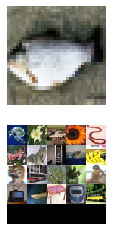

In [9]:
pairs, targets = make_oneshot_task(20, x_train_20)
plot_oneshot_task(pairs)

In [11]:
loops = 200
best_acc = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(siamese_net, x_train_80)
    test_acc = test_oneshot(siamese_net, x_train_20)
    if test_acc >= best_acc:
        print("New best one-shot accuracy, saving model ...")
        #siamese_net.save(os.path.join("models", "siamese_omniglot.h5"))
        best_acc = test_acc

=== Training loop 1 ===
Epoch 1/1
100/100 [==============================] - 15s 149ms/step - loss: 0.8310
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 2 ===
Epoch 1/1
100/100 [==============================] - 12s 119ms/step - loss: 0.7327
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.2% accuracy for 20-way one-shot learning
=== Training loop 3 ===
Epoch 1/1
 84/100 [========================>.....] - ETA: 1s - loss: 0.7085100/100 [==============================] - 12s 119ms/step - loss: 0.7045
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 7.2% accuracy for 20-way one-shot learning
=== Training loop 4 ===
Epoch 1/1
100/100 [==============================] - 12s 119ms/step - loss: 0.6873
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average 

 11/100 [==>...........................] - ETA: 10s - loss: 0.6453100/100 [==============================] - 12s 119ms/step - loss: 0.6446
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 66 ===
Epoch 1/1
100/100 [==============================] - 12s 120ms/step - loss: 0.6369
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.4% accuracy for 20-way one-shot learning
=== Training loop 67 ===
Epoch 1/1
100/100 [==============================] - 12s 120ms/step - loss: 0.6387
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 15.2% accuracy for 20-way one-shot learning
=== Training loop 68 ===
Epoch 1/1
 11/100 [==>...........................] - ETA: 10s - loss: 0.6410100/100 [==============================] - 12s 119ms/step - loss: 0.6533
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.

 12/100 [==>...........................] - ETA: 10s - loss: 0.6172100/100 [==============================] - 12s 119ms/step - loss: 0.6320
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
=== Training loop 98 ===
Epoch 1/1
100/100 [==============================] - 12s 120ms/step - loss: 0.6283
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 99 ===
Epoch 1/1
100/100 [==============================] - 12s 119ms/step - loss: 0.6291
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.0% accuracy for 20-way one-shot learning
=== Training loop 100 ===
Epoch 1/1
 11/100 [==>...........................] - ETA: 10s - loss: 0.6016100/100 [==============================] - 12s 119ms/step - loss: 0.6350
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13

  5/100 [>.............................] - ETA: 11s - loss: 0.6019100/100 [==============================] - 12s 119ms/step - loss: 0.6196
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 18.0% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 130 ===
Epoch 1/1
100/100 [==============================] - 12s 119ms/step - loss: 0.6240
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 17.2% accuracy for 20-way one-shot learning
=== Training loop 131 ===
Epoch 1/1
100/100 [==============================] - 12s 120ms/step - loss: 0.6213
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 16.4% accuracy for 20-way one-shot learning
=== Training loop 132 ===
Epoch 1/1
100/100 [==============================] - 12s 119ms/step - loss: 0.6238
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.8% accuracy for 20

 11/100 [==>...........................] - ETA: 10s - loss: 0.5989100/100 [==============================] - 12s 120ms/step - loss: 0.6128
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 16.0% accuracy for 20-way one-shot learning
=== Training loop 162 ===
Epoch 1/1
100/100 [==============================] - 12s 119ms/step - loss: 0.6244
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.4% accuracy for 20-way one-shot learning
=== Training loop 163 ===
Epoch 1/1
100/100 [==============================] - 12s 120ms/step - loss: 0.6179
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 18.8% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 164 ===
Epoch 1/1
 10/100 [==>...........................] - ETA: 10s - loss: 0.6229100/100 [==============================] - 12s 119ms/step - loss: 0.6293
Evaluating model on 250 random 20-way o

 11/100 [==>...........................] - ETA: 10s - loss: 0.6174100/100 [==============================] - 12s 119ms/step - loss: 0.6182
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 16.4% accuracy for 20-way one-shot learning
=== Training loop 194 ===
Epoch 1/1
100/100 [==============================] - 12s 119ms/step - loss: 0.6243
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 15.2% accuracy for 20-way one-shot learning
=== Training loop 195 ===
Epoch 1/1
100/100 [==============================] - 12s 119ms/step - loss: 0.6150
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 18.4% accuracy for 20-way one-shot learning
=== Training loop 196 ===
Epoch 1/1
 11/100 [==>...........................] - ETA: 10s - loss: 0.6023100/100 [==============================] - 12s 119ms/step - loss: 0.6119
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 

***

**b)** Briefly motivate your model's architecture, as well as its performance. What accuracy would random guessing achieve (on average)?

**Answer:**

*=== write your answer here ===*

***

**c)** Compare the performance of your Siamese network for Cifar-100 to the Siamese network from Practical 4 for Omniglot. Name three fundamental differences between the Cifar-100 and Omniglot datasets. How do these differences influence the difference in one-shot accuracy?

**Answer:**

*=== write your answer here ===*

***1: Type of images: greyscale shapes (one shape = one meaning) vs. versatile RGB images (various shapes can mean same thing). 2: Omniglot has fewer examples per class than Cifar-100. 3: Omniglot has way more classes than Cifar-100.
The first difference outweighs the other two, making one-shot learning on Cifar-100 much harder.***

***

### Task 1.2: One-shot learning with neural codes
**a)**
* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

In [0]:
# reshape data for training classifier
x_train_80 = x_train_80.reshape(-1, img_rows, img_cols, chns)
x_test_80 = x_test_80.reshape(-1, img_rows, img_cols, chns)

# transform 80 labels to one-hot
y_train_80 = to_categorical(y_train_80)
y_test_80 = to_categorical(y_test_80)

In [30]:
# cnn architecture
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu', name="neural_codes"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(80, activation='softmax'))

cnn.summary()

cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 64)        0         
__________

In [31]:
batch_size = 100
epochs = 20

cnn.fit(x_train_80, y_train_80,
        batch_size=batch_size,
        epochs=epochs)

Epoch 1/20
40000/40000 [==============================] - 14s 349us/step - loss: 3.8909 - acc: 0.1201
Epoch 2/20
40000/40000 [==============================] - 13s 330us/step - loss: 3.2270 - acc: 0.2146
Epoch 3/20
24500/40000 [=================>............] - ETA: 5s - loss: 2.9487 - acc: 0.262940000/40000 [==============================] - 13s 328us/step - loss: 2.9193 - acc: 0.2691
Epoch 4/20
40000/40000 [==============================] - 13s 332us/step - loss: 2.7035 - acc: 0.3135
Epoch 5/20
34300/40000 [========================>.....] - ETA: 1s - loss: 2.5532 - acc: 0.342640000/40000 [==============================] - 13s 331us/step - loss: 2.5579 - acc: 0.3418
Epoch 6/20
40000/40000 [==============================] - 13s 331us/step - loss: 2.4335 - acc: 0.3677
Epoch 7/20
38300/40000 [===========================>..] - ETA: 0s - loss: 2.3449 - acc: 0.383640000/40000 [==============================] - 13s 329us/step - loss: 2.3481 - acc: 0.3834
Epoch 8/20
40000/40000 [=============

In [32]:
loss, accuracy = cnn.evaluate(x_test_80, y_test_80, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.139175796866417
Test accuracy: 0.44375


In [0]:
cnn_nc = Model(inputs=cnn.input, outputs=cnn.get_layer("neural_codes").output)

def test_oneshot_nc(model_nc, X, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy for L2-distance between neural codes over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X)
        # this part of the code is new:
        test_image = inputs[0]
        support_set = inputs[1]
        test_image_nc = model_nc.predict(test_image)
        support_set_nc = model_nc.predict(support_set)
        mse = np.mean((test_image_nc - support_set_nc)**2, axis=1)  # mean squared error is proportional to L2 distance
        # back to the old code:
        if np.argmin(mse) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

In [69]:
test_oneshot_nc(cnn_nc, x_test_20)

Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 20.8% accuracy for 20-way one-shot learning


20.8

***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:**

*=== write your answer here ===*